In [1]:
import os
import numpy as np
from scipy.io import wavfile
from hmmlearn import hmm
import sklearn.mixture as skm
import utils
import enroll
import Validate
import pickle
from sklearn import preprocessing
from scipy.signal import butter, sosfilt, sosfreqz
import python_speech_features as mfcc

import matplotlib.pyplot as plt

In [11]:
WINLEN = 0.025
WINSTEP = 0.01

def getMFCC(audio_signal, sample_rate, single_phrase=False, mutliple_phrases = False, NUM_FEAT = 13, ENERGY = True , Delta = False, Filter = False):
    
    if(Filter):
        audio_signal = butter_bandpass_filter(audio_signal, 300, 3000, sample_rate, order=5)

    if (single_phrase):
        audio_signal = remove_silence(audio_signal,sample_rate,10,60,dev=3,single_phrase=True)
    if (mutliple_phrases):
        audio_signal = remove_silence(audio_signal,sample_rate,10,60,dev=1,mutliple_phrases = True)
        
    mfcc_features = mfcc.mfcc(audio_signal, sample_rate, winlen=WINLEN,winstep=WINSTEP,numcep=-NUM_FEAT,winfunc=np.hamming,appendEnergy=ENERGY)
    print("Features before scale",mfcc_features.shape)
    features = preprocessing.scale(mfcc_features)
    print("Features after scale",features.shape)

    if(Delta):
        delta_feat = mfcc.delta(mfcc_features, 2)
        delta_delta_feat = mfcc.delta(delta_feat, 2)
        print("Delta Features",delta_feat.shape,delta_delta_feat.shape)

        features = [features, delta_feat, delta_delta_feat]
        features = np.concatenate(features,axis=1)

    
    return features

In [20]:
def remove_silence(audio_signal,sample_rate,startframes = 10, endframes =10, dev = 3, single_phrase=False, mutliple_phrases = False):
    preemph=0.97
    winlen=0.01
    FFT = 512
    framelen = winlen*sample_rate
    signal = mfcc.sigproc.preemphasis(audio_signal,preemph)
    frames = mfcc.sigproc.framesig(signal, framelen,  framelen)
    numOfFrames,sizeOfFrame = frames.shape
   
    powerspec = mfcc.sigproc.powspec(frames,FFT)
    energy = np.sum(powerspec,1)
    
    
    first_samples = np.concatenate((energy[:startframes], energy[:-endframes]), axis=None)
    mean = np.mean(first_samples)
    std = np.std(first_samples)
    indexes = np.array([]) #frames to keep

    temp = []
    for i in range(len(energy)):
        d = (abs(energy[i]- mean))/std
#         print(d)
        if(d>dev): 
            if(len(indexes) == 0):
                indexes = [i]
            else:
                indexes= np.append(indexes,i)
        temp.append(d)
        
    plt.plot(temp)
    
    plt.axhline(y=dev, color='r', linestyle='-')
    plt.show()
    
    if(single_phrase):
        start = int((indexes[0])*framelen)
        stop = int((indexes[-2]+5)*framelen)
        cleaned_signal= mfcc.sigproc.deframesig(frames[indexes],stop-start,framelen, framelen)
    elif(mutliple_phrases):
        cleaned_signal =  mfcc.sigproc.deframesig(frames[indexes],0,framelen, framelen)
    else:
        raise ValueError("Need to specify how to split")
        
    plt.plot(cleaned_signal)
    plt.show()

    return cleaned_signal

In [21]:
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

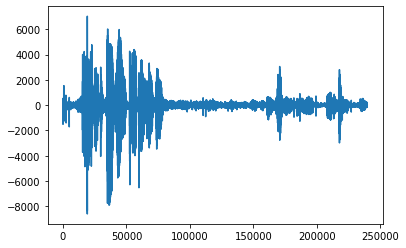

In [22]:
sampling_rate, audio_signal = wavfile.read('../data\\Speaker1\\phrases\\412235_Speaker1_s.wav')
plt.plot(audio_signal)
plt.show()

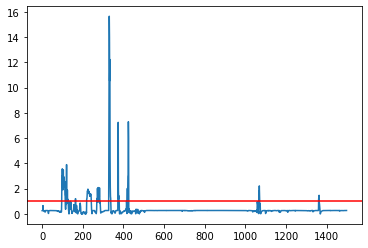

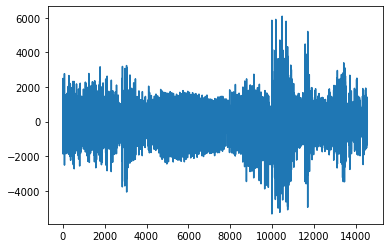

Features before scale (90, 13)
Features after scale (90, 13)
Delta Features (90, 13) (90, 13)


(90, 39)

In [4]:
from ubm_model import UBM
import pickle

In [5]:
voice_commands_files = pickle.load(open("ubm_data.f","rb"))
ubm_model = UBM()
ubm_model.loadtrainingfeatures(voice_commands_files)
ubm_model.trainHMMUBM()